In [16]:
import numpy as np
import pandas as pd
import pickle
import sys
import os
import dsc
from dsc.query_engine import Query_Processor as dscQP
from dsc import dsc_io

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)

import utils

In [17]:
def stratify_dfcol(df, colname, value):
    #return pd_utils.select_dfrows(df, [f"$({colname}) == {value}"])
    return df.loc[df[colname] == value]

def stratify_dfcols(df, condition_list):
    for (colname, value) in condition_list:
        df = stratify_dfcol(df, colname, value)
    return df

def stratify_dfcols_in_list(df, colname, values):
    return df.loc[df[colname].isin(values)]

In [18]:
dsc_output = "/home/saikatbanerjee/scratch/work/gradvi-experiments/linreg_corr"
dsc_fname  = os.path.basename(os.path.normpath(dsc_output))
db = os.path.join(dsc_output, dsc_fname + ".db")
elbopkl   = os.path.join("../dsc/results", dsc_fname + "_elbo.pkl")
dscoutpkl = os.path.join("../dsc/results", dsc_fname + "_dscout.pkl")
dscout    = pd.read_pickle(dscoutpkl)

refresh_pickle = False

print(db)
plotprefix = "compare_elbo_rmse_linreg_blockcorr"

/home/saikatbanerjee/scratch/work/gradvi-experiments/linreg_corr/linreg_corr.db


In [19]:
target = ["simulate", "simulate.sfix", "simulate.pve", "simulate.se", "simulate.dims", "fit"]
#condition = ["simulate.sfix == 2", "simulate.signal == 'normal'", "simulate.dims == '(50, 200)'"]
#groups = ["fit_cpt:"]
condition = [""]

In [20]:
qp = dscQP(db, target, condition)
qp_df = qp.output_table
df    = stratify_dfcols_in_list(qp_df, 'fit', ['gradvi_direct', 'gradvi_compound', 'mr_ash', 'mr_ash_lasso_init'])
df

,DSC,simulate,simulate.sfix,simulate.se:output,simulate.pve,simulate.output.file,simulate.dims,fit,fit.output.file
0,1,blockdiag,2,blockdiag/blockdiag_1,0.4,blockdiag/blockdiag_1,"(500,10000)",mr_ash,mr_ash/blockdiag_1_mr_ash_1
1,1,blockdiag,5,blockdiag/blockdiag_2,0.4,blockdiag/blockdiag_2,"(500,10000)",mr_ash,mr_ash/blockdiag_2_mr_ash_1
2,1,blockdiag,10,blockdiag/blockdiag_3,0.4,blockdiag/blockdiag_3,"(500,10000)",mr_ash,mr_ash/blockdiag_3_mr_ash_1
3,1,blockdiag,20,blockdiag/blockdiag_4,0.4,blockdiag/blockdiag_4,"(500,10000)",mr_ash,mr_ash/blockdiag_4_mr_ash_1
4,1,blockdiag,2,blockdiag/blockdiag_5,0.6,blockdiag/blockdiag_5,"(500,10000)",mr_ash,mr_ash/blockdiag_5_mr_ash_1
...,...,...,...,...,...,...,...,...,...
475,10,blockdiag,20,blockdiag/blockdiag_116,0.6,blockdiag/blockdiag_116,"(500,10000)",gradvi_compound,gradvi_compound/blockdiag_116_gradvi_compound_1
476,10,blockdiag,2,blockdiag/blockdiag_117,0.8,blockdiag/blockdiag_117,"(500,10000)",gradvi_compound,gradvi_compound/blockdiag_117_gradvi_compound_1
477,10,blockdiag,5,blockdiag/blockdiag_118,0.8,blockdiag/blockdiag_118,"(500,10000)",gradvi_compound,gradvi_compound/blockdiag_118_gradvi_compound_1
478,10,blockdiag,10,blockdiag/blockdiag_119,0.8,blockdiag/blockdiag_119,"(500,10000)",gradvi_compound,gradvi_compound/blockdiag_119_gradvi_compound_1


In [21]:
def read_result(df, method):
    '''
    must be a single row after method selection
    '''
    dfm = stratify_dfcol(df, "fit", method)
    assert(dfm.shape[0] == 1)
    fprefix = dfm['fit.output.file'].values[0]
    ext = 'pkl' if method.startswith('gradvi') else 'rds'
    fname = os.path.join(dsc_output, f"{fprefix}.{ext}")
    data = dsc_io.load_dsc(fname)
    return data


def get_elbo_from_result(data, method):
    if method.startswith('gradvi'):
        return data['model']['elbo_path'][-1]
    else:
        return data['model']['fit']['varobj'][-1]
    
def get_convergence_from_result(data, method, mrash_maxiter = 2000):
    '''
    1: converged
    2: abnormal termination
    3: number of iterations reached limit
    4: unknown
    '''
    if method.startswith('gradvi'):
        success = data['model']['success']
        if success:
            conv_status = 1
        else:
            conv_message = data['model']['fitobj']['message']
            if "ITERATIONS REACHED LIMIT" in conv_message:
                conv_status = 3
            elif "ABNORMAL_TERMINATION_IN_LNSRCH" in conv_message:
                conv_status = 2
            else:
                conv_status = 4
    else:
        niter = data['model']['fit']['iter']
        if niter == mrash_maxiter:
            conv_status = 3
        else:
            conv_status = 1
    return conv_status

def get_mse_from_dscout(df, sfix, pve, dsc, method):
    dfrows = stratify_dfcols(df, 
                             [("simulate.sfix", sfix), 
                              ("simulate.pve", pve), 
                              ("DSC", dsc), 
                              ("fit", method)])
    mse = dfrows[~dfrows['mse.err'].isnull()]['mse.err'].values
    if len(mse) == 1:
        return mse[0]
    else:
        print ("Error fetching value")
        return mse[0]
    
def get_elbodf(df):
    methods = df['fit'].unique()
    sfixs   = df['simulate.sfix'].unique()
    pves    = df['simulate.pve'].unique()
    resdict = {'simulate.sfix': [], 'simulate.pve': [], 'DSC': [], 
               **{x: [] for x in methods}, 
               **{f"{x}_status": [] for x in methods}
              }
    for pve in pves:
        for sfix in sfixs:
            dfs = stratify_dfcols(df, [('simulate.sfix', sfix), ("simulate.pve", pve)])

            dscids = dfs['DSC'].unique()
            for idsc in dscids:
                dfs0 = stratify_dfcol(dfs, 'DSC', idsc)
                resdict['simulate.sfix'].append(sfix)
                resdict['simulate.pve'].append(pve)
                resdict['DSC'].append(idsc)
                for method in methods:
                    data = read_result(dfs0, method)
                    elbo = get_elbo_from_result(data, method)
                    conv_status = get_convergence_from_result(data, method)
                    resdict[method].append(elbo)    
                    resdict[f"{method}_status"].append(conv_status)
    return pd.DataFrame.from_dict(resdict)

def get_msedf(elbodf, dscdf):
    methods = [x[:-7] for x in list(elbodf.columns) if x.endswith("_status")]
    msedict = elbodf.to_dict()
    ikeys = list(msedict['simulate.sfix'].keys())
    for method in methods:
        for i in ikeys:
            mse = get_mse_from_dscout(dscout, 
                          msedict['simulate.sfix'][i], 
                          msedict['simulate.pve'][i],
                          msedict['DSC'][i], 
                          method)
            msedict[method][i] = mse
    return pd.DataFrame.from_dict(msedict)

def outlier_index(data):
    q3, q1 = np.percentile(data, [75, 25])
    iqr = q3 - q1
    xmin = q1 - 1.5 * iqr
    xmax = q3 + 1.5 * iqr
    keepidx = np.where(np.logical_and(data >= xmin, data <= xmax))
    outlieridx = np.where(np.logical_or(data < xmin, data > xmax))
    return outlieridx, keepidx

def outlier_index_normal(data, factor = 0.9):
    q3, q1 = np.percentile(data, [75 ,25])
    iqr = q3 - q1
    # In ANY normal distribution: IQR = Q3 - Q1 = 0.67448σ - (-0.67448σ) = 1.34896σ
    iqr_sigma = iqr / 1.34896
    median = np.median(data)
    xmin = median - factor * iqr_sigma
    xmax = median + factor * iqr_sigma
    keepidx = np.where(np.logical_and(data >= xmin, data <= xmax))
    outlieridx = np.where(np.logical_or(data < xmin, data > xmax))
    return outlieridx, keepidx

In [22]:
if refresh_pickle:
    elbodf = get_elbodf(df)
    elbodf.to_pickle(elbopkl)
else:
    elbodf = pd.read_pickle(elbopkl)

In [23]:
## remove sfix = 1
elbodf = stratify_dfcols_in_list(elbodf, "simulate.sfix", [2, 5, 10, 20])
msedf = get_msedf(elbodf, dscout)

In [24]:
## Drop rows which did not converge
def filter_convergence_status(df, methods = [], remove_status = [2, 3, 4]):
    if len(methods) == 0:
        methods = [x[:-7] for x in list(df.columns) if x.endswith("_status")]
    for method in methods:
        for sidx in remove_status:
            df = df[df[f"{method}_status"] != sidx]
    return df
elbodf_filtered = filter_convergence_status(elbodf, remove_status = [2, 4])
msedf_filtered  = filter_convergence_status(msedf,  remove_status = [2, 4])
elbodf_filtered

,simulate.sfix,simulate.pve,DSC,mr_ash,mr_ash_lasso_init,gradvi_direct,gradvi_compound,mr_ash_status,mr_ash_lasso_init_status,gradvi_direct_status,gradvi_compound_status
0,2,0.4,1,45.118440,24.027089,52.889707,24.514484,1,1,1,1
1,2,0.4,2,1141.450048,1119.168474,1154.852307,1119.576781,1,1,3,1
2,2,0.4,3,612.137333,612.136402,641.928341,596.558639,1,1,1,1
3,2,0.4,4,1192.488452,1174.880257,1193.194599,1174.849111,1,1,1,1
4,2,0.4,5,910.915673,892.969972,899.801459,892.941383,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
115,20,0.8,6,1366.084786,1340.552013,1366.355746,1318.238886,1,1,1,1
116,20,0.8,7,1229.688501,1228.219048,1230.535359,1200.772301,1,1,1,1
117,20,0.8,8,1050.558368,972.551831,1008.139606,983.775283,1,1,1,1
118,20,0.8,9,1189.282003,1122.797427,1193.005415,1142.771955,1,1,1,1


In [25]:
msedf

,simulate.sfix,simulate.pve,DSC,mr_ash,mr_ash_lasso_init,gradvi_direct,gradvi_compound,mr_ash_status,mr_ash_lasso_init_status,gradvi_direct_status,gradvi_compound_status
0,2,0.4,1,0.069623,0.064422,0.067863,0.064522,1,1,1,1
1,2,0.4,2,4.756549,4.371802,4.580207,4.385927,1,1,3,1
2,2,0.4,3,0.615273,0.615374,0.609993,0.608453,1,1,1,1
3,2,0.4,4,5.859945,6.170096,5.859629,6.172796,1,1,1,1
4,2,0.4,5,2.163899,2.032447,2.032446,2.032304,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
115,20,0.8,6,10.755972,10.385242,10.756965,10.372830,1,1,1,1
116,20,0.8,7,6.168268,5.341540,6.167810,6.763859,1,1,1,1
117,20,0.8,8,3.020773,2.280565,2.838199,2.787267,1,1,1,1
118,20,0.8,9,6.605616,5.003627,6.326592,6.062046,1,1,1,1


In [26]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)

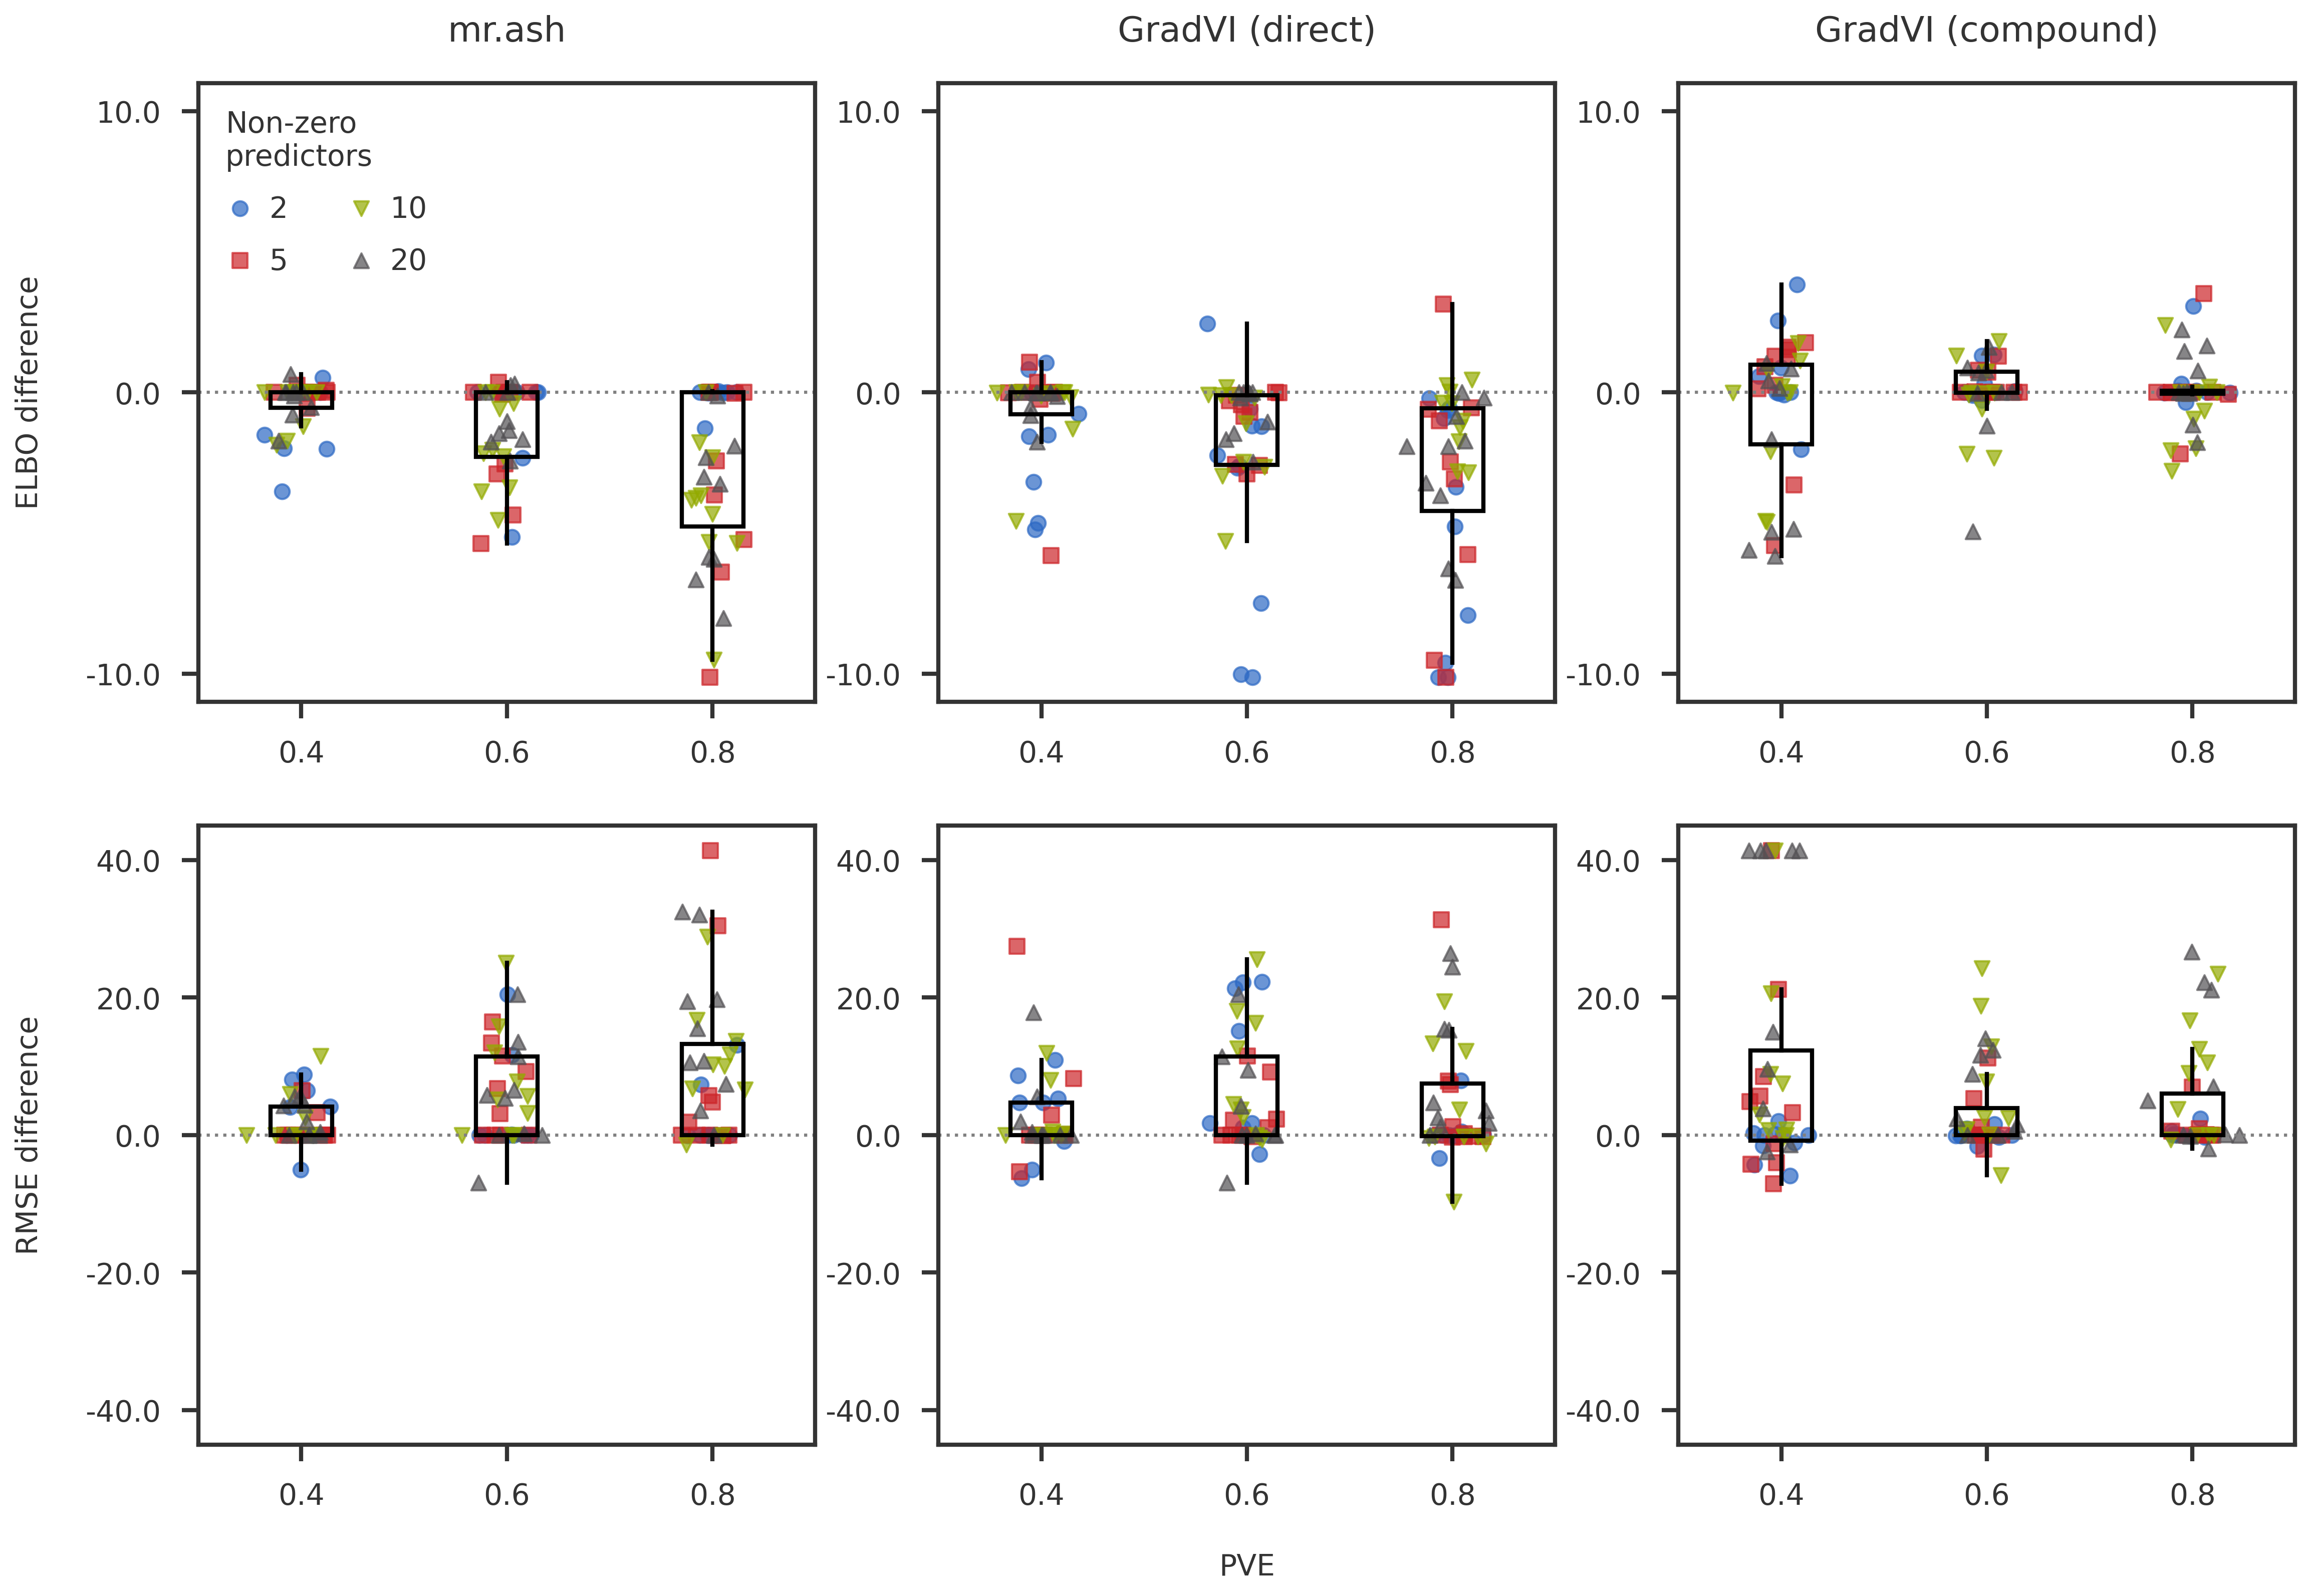

In [30]:
def np_categorize(arr):
    unq = np.unique(arr)
    d1  = {x : i for i, x in enumerate(unq)}
    d2  = {i : x for i, x in enumerate(unq)}
    return np.array([d1[x] for x in arr]), d2

def rand_jitter(arr, d = 0.04):
    stdev = d * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def truncate_jitter(arr, ylim, d = 0.04):
    xnew  = arr.copy()
    if ylim is not None:
        ydev  = d * (ylim[1] - ylim[0])
        ilow  = np.where(xnew < ylim[0] + ydev)[0]
        ihigh = np.where(xnew > ylim[1] - ydev)[0]
        if len(ilow) > 0:
            xnew[ilow]  = ylim[0] + ydev #+ np.abs(np.random.randn(len(ilow))) * ydev
        if len(ihigh) > 0:
            xnew[ihigh] = ylim[1] - ydev
    return xnew

def match_index(idx1, idx2):
    return np.intersect1d(idx1, idx2, assume_unique = True)

def plot_elbo_boxplot(ax, df, reference, target, 
                      factr = -1,
                      has_outliers = False, use_gradvi_alternate = False,
                      showboxplot = True, showscatter = True, showlegend = True,
                      ylim = None, debug = False):

    ref  = factr * df[reference].to_numpy()
    tgt  = factr * df[target].to_numpy()
    diff = (tgt - ref) * 100 / np.abs(ref)

    sfixidx, sfixvals = np_categorize(df['simulate.sfix'].to_numpy())
    pveidx,  pvevals  = np_categorize(df['simulate.pve'].to_numpy())

    if has_outliers:
        iremove = np.array([])
        ikeep   = np.arange(diff.shape[0])
    else:
        iremove, ikeep = outlier_index_normal(diff, factor = 10.0)
        if debug:
            print (f"Number of outliers removed : {iremove[0].shape[0]}")
            for i in iremove[0]:
                print(f"Index {i},\tPVE={pvevals[pveidx[i]]}, s={sfixvals[sfixidx[i]]}\t diff = {diff[i]:g}")

    ax.axhline(y = 0, linestyle = 'dotted', color = 'gray')
    if ylim is not None: ax.set_ylim(ylim)
    xvals = list(pvevals.keys())
    xlabels = list(pvevals.values())

    # Box plot for each PVE
    if showboxplot:
        boxcolor = '#000000'
        boxface = f'#{boxcolor[1:]}00' #https://stackoverflow.com/questions/15852122/hex-transparency-in-colors
        #boxface = 'white'
        medianprops = dict(linewidth=0, color = boxcolor)
        whiskerprops = dict(linewidth=2, color = boxcolor)
        boxprops = dict(linewidth=2, color = boxcolor, facecolor = boxface)
        flierprops = dict(marker='o', markerfacecolor=boxface, markersize=3, markeredgecolor = boxcolor)

        ax.boxplot([diff[match_index(np.where(pveidx == i)[0], ikeep)] for i in xvals],
                   positions = xvals,
                   showcaps = False, showfliers = False, 
                   widths = 0.3, patch_artist = True, notch = False,
                   flierprops = flierprops, boxprops = boxprops, 
                   medianprops = medianprops, whiskerprops = whiskerprops)      

    # Scatter plot with jitter, showing sfix
    if showscatter:
        mcolors  = mpl_stylesheet.banskt_colors()
        mmarkers = ['o', 's', 'v', '^', '<', '>', 'p', 'h', 'H', 'D', 'd']
        xpve = rand_jitter(pveidx)
        diff_trunc = truncate_jitter(diff, ylim)
        for sidx, sfix in sfixvals.items():
            marker  = mmarkers[sidx]
            color   = mcolors[sidx]
            _idx    = np.where(sfixidx == sidx)[0]
            _ikeep  = np.intersect1d(_idx, ikeep, assume_unique = True)
            ax.scatter(xpve[_ikeep], diff_trunc[_ikeep], marker = marker, c = color,
                       alpha = 0.7, s = 50, linewidth = 1, label = f"{sfix}")
        # legend for number of causal predictors
        if showlegend:
            mhandles, mlabels = ax.get_legend_handles_labels()
            leg1 = ax.legend(handles = mhandles, labels = mlabels, title = "Non-zero\npredictors",
                             loc = 'upper left', bbox_to_anchor = (0.02, 0.98), ncol = 2)
            leg1._legend_box.align = "left"
            
    ax.set_xticks(xvals)
    ax.set_xticklabels(xlabels)
    #mpl_utils.set_yticks(ax, scale = 'linear', spacing = 'linear', fmt = '{:.1f}')
    mpl_utils.set_yticks(ax, scale = 'linear', spacing = 'linear')

fig = plt.figure(figsize = (18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

#elbo_ylim = None #[-2.1, 1.2]
elbo_ylim = [-11, 11]

#ax1.scatter(rand_jitter(pveidx), diff, alpha = 0.5)
plot_elbo_boxplot(ax1, elbodf_filtered, 
                  "mr_ash_lasso_init", "mr_ash", showboxplot = True,
                  has_outliers = False, ylim = elbo_ylim)
plot_elbo_boxplot(ax2, elbodf_filtered, 
                  "mr_ash_lasso_init", "gradvi_direct", showlegend = False,
                  has_outliers = False, ylim = elbo_ylim)
plot_elbo_boxplot(ax3, elbodf_filtered, 
                  "mr_ash_lasso_init", "gradvi_compound", showlegend = False,
                  has_outliers = False, ylim = elbo_ylim)

mse_ylim = [-45, 45]
#mse_ylim = None
plot_elbo_boxplot(ax4, msedf_filtered,
                  "mr_ash_lasso_init", "mr_ash", showlegend = False,
                  factr = 1, has_outliers = False, ylim = mse_ylim)
plot_elbo_boxplot(ax5, msedf_filtered,
                  "mr_ash_lasso_init", "gradvi_direct", showlegend = False,
                  factr = 1, has_outliers = False, ylim = mse_ylim)
plot_elbo_boxplot(ax6, msedf_filtered,
                  "mr_ash_lasso_init", "gradvi_compound", showlegend = False,
                  factr = 1, has_outliers = False, ylim = mse_ylim)


ax1.set_ylabel(r"ELBO difference")
ax1.set_title("mr.ash", pad = 20)
ax2.set_title("GradVI (direct)", pad = 20)
ax3.set_title("GradVI (compound)", pad = 20)
ax4.set_ylabel(r"RMSE difference")
ax5.set_xlabel("PVE")

utils.saveplot(fig, plotprefix)
plt.show()

In [18]:
msedf

,simulate.sfix,simulate.pve,DSC,mr_ash,mr_ash_lasso_init,gradvi_direct,gradvi_compound,mr_ash_status,mr_ash_lasso_init_status,gradvi_direct_status,gradvi_compound_status
0,2,0.4,1,0.069623,0.064422,0.067863,0.064522,1,1,1,1
1,2,0.4,2,4.756549,4.371802,4.580207,4.385927,1,1,3,1
2,2,0.4,3,0.615273,0.615374,0.609993,0.608453,1,1,1,1
3,2,0.4,4,5.859945,6.170096,5.859629,6.172796,1,1,1,1
4,2,0.4,5,2.163899,2.032447,2.032446,2.032304,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
115,20,0.8,6,10.755972,10.385242,10.756965,10.372830,1,1,1,1
116,20,0.8,7,6.168268,5.341540,6.167810,6.763859,1,1,1,1
117,20,0.8,8,3.020773,2.280565,2.838199,2.787267,1,1,1,1
118,20,0.8,9,6.605616,5.003627,6.326592,6.062046,1,1,1,1


In [31]:
stratify_dfcols(elbodf, [('simulate.sfix', 20), ('simulate.pve', 0.4)])

,simulate.sfix,simulate.pve,DSC,mr_ash,mr_ash_lasso_init,gradvi_direct,gradvi_compound,mr_ash_status,mr_ash_lasso_init_status,gradvi_direct_status,gradvi_compound_status
30,20,0.4,1,1771.827976,1771.827979,1771.828317,1857.707680,1,1,1,1
31,20,0.4,2,1458.871811,1468.490402,1468.572399,1453.187070,1,1,1,1
32,20,0.4,3,1756.315041,1756.315041,1756.316384,1843.411173,1,1,1,1
33,20,0.4,4,1422.140719,1422.140720,1422.385312,1513.720816,1,1,1,1
34,20,0.4,5,1825.032908,1825.281447,1825.281406,1927.400968,1,1,1,1
35,20,0.4,6,1666.754728,1658.145813,1666.755441,1754.608403,1,1,1,1
36,20,0.4,7,1462.261251,1462.261235,1462.375632,1450.003361,1,1,1,1
37,20,0.4,8,1314.594374,1312.936954,1314.731849,1307.556111,1,1,1,1
38,20,0.4,9,1227.715968,1207.027596,1228.141645,1227.245871,1,1,1,1
39,20,0.4,10,1295.469527,1285.348247,1295.700488,1283.344833,1,1,1,1


In [32]:
stratify_dfcols(msedf, [('simulate.sfix', 20), ('simulate.pve', 0.4)])

,simulate.sfix,simulate.pve,DSC,mr_ash,mr_ash_lasso_init,gradvi_direct,gradvi_compound,mr_ash_status,mr_ash_lasso_init_status,gradvi_direct_status,gradvi_compound_status
30,20,0.4,1,63.935226,63.934946,63.934060,98.139245,1,1,1,1
31,20,0.4,2,19.065361,18.286567,18.286344,18.993634,1,1,1,1
32,20,0.4,3,54.569523,54.569377,54.568038,87.335504,1,1,1,1
33,20,0.4,4,15.685945,15.686109,15.687809,24.363558,1,1,1,1
34,20,0.4,5,85.522284,80.975183,80.977033,131.298628,1,1,1,1
35,20,0.4,6,42.651332,41.835226,42.652613,66.432710,1,1,1,1
36,20,0.4,7,19.658146,19.657564,19.657712,21.550755,1,1,1,1
37,20,0.4,8,10.418486,9.861648,10.413568,9.623912,1,1,1,1
38,20,0.4,9,6.765772,6.483112,7.641940,7.457677,1,1,1,1
39,20,0.4,10,10.984688,10.941169,10.985403,10.787359,1,1,1,1


Number of outliers removed : 13
Index 6,	PVE=0.4, s=2	 diff = -33.1946
Index 8,	PVE=0.4, s=2	 diff = -119.781
Index 17,	PVE=0.4, s=5	 diff = -68.6018
Index 26,	PVE=0.4, s=10	 diff = -28.6062
Index 31,	PVE=0.4, s=20	 diff = -2.35387
Index 37,	PVE=0.4, s=20	 diff = -20.6277
Index 44,	PVE=0.6, s=2	 diff = -203.527
Index 50,	PVE=0.6, s=5	 diff = -145.539
Index 56,	PVE=0.6, s=5	 diff = -175.501
Index 80,	PVE=0.8, s=2	 diff = -167.667
Index 86,	PVE=0.8, s=2	 diff = -283.861
Index 92,	PVE=0.8, s=5	 diff = -131.686
Index 114,	PVE=0.8, s=20	 diff = -4.48612


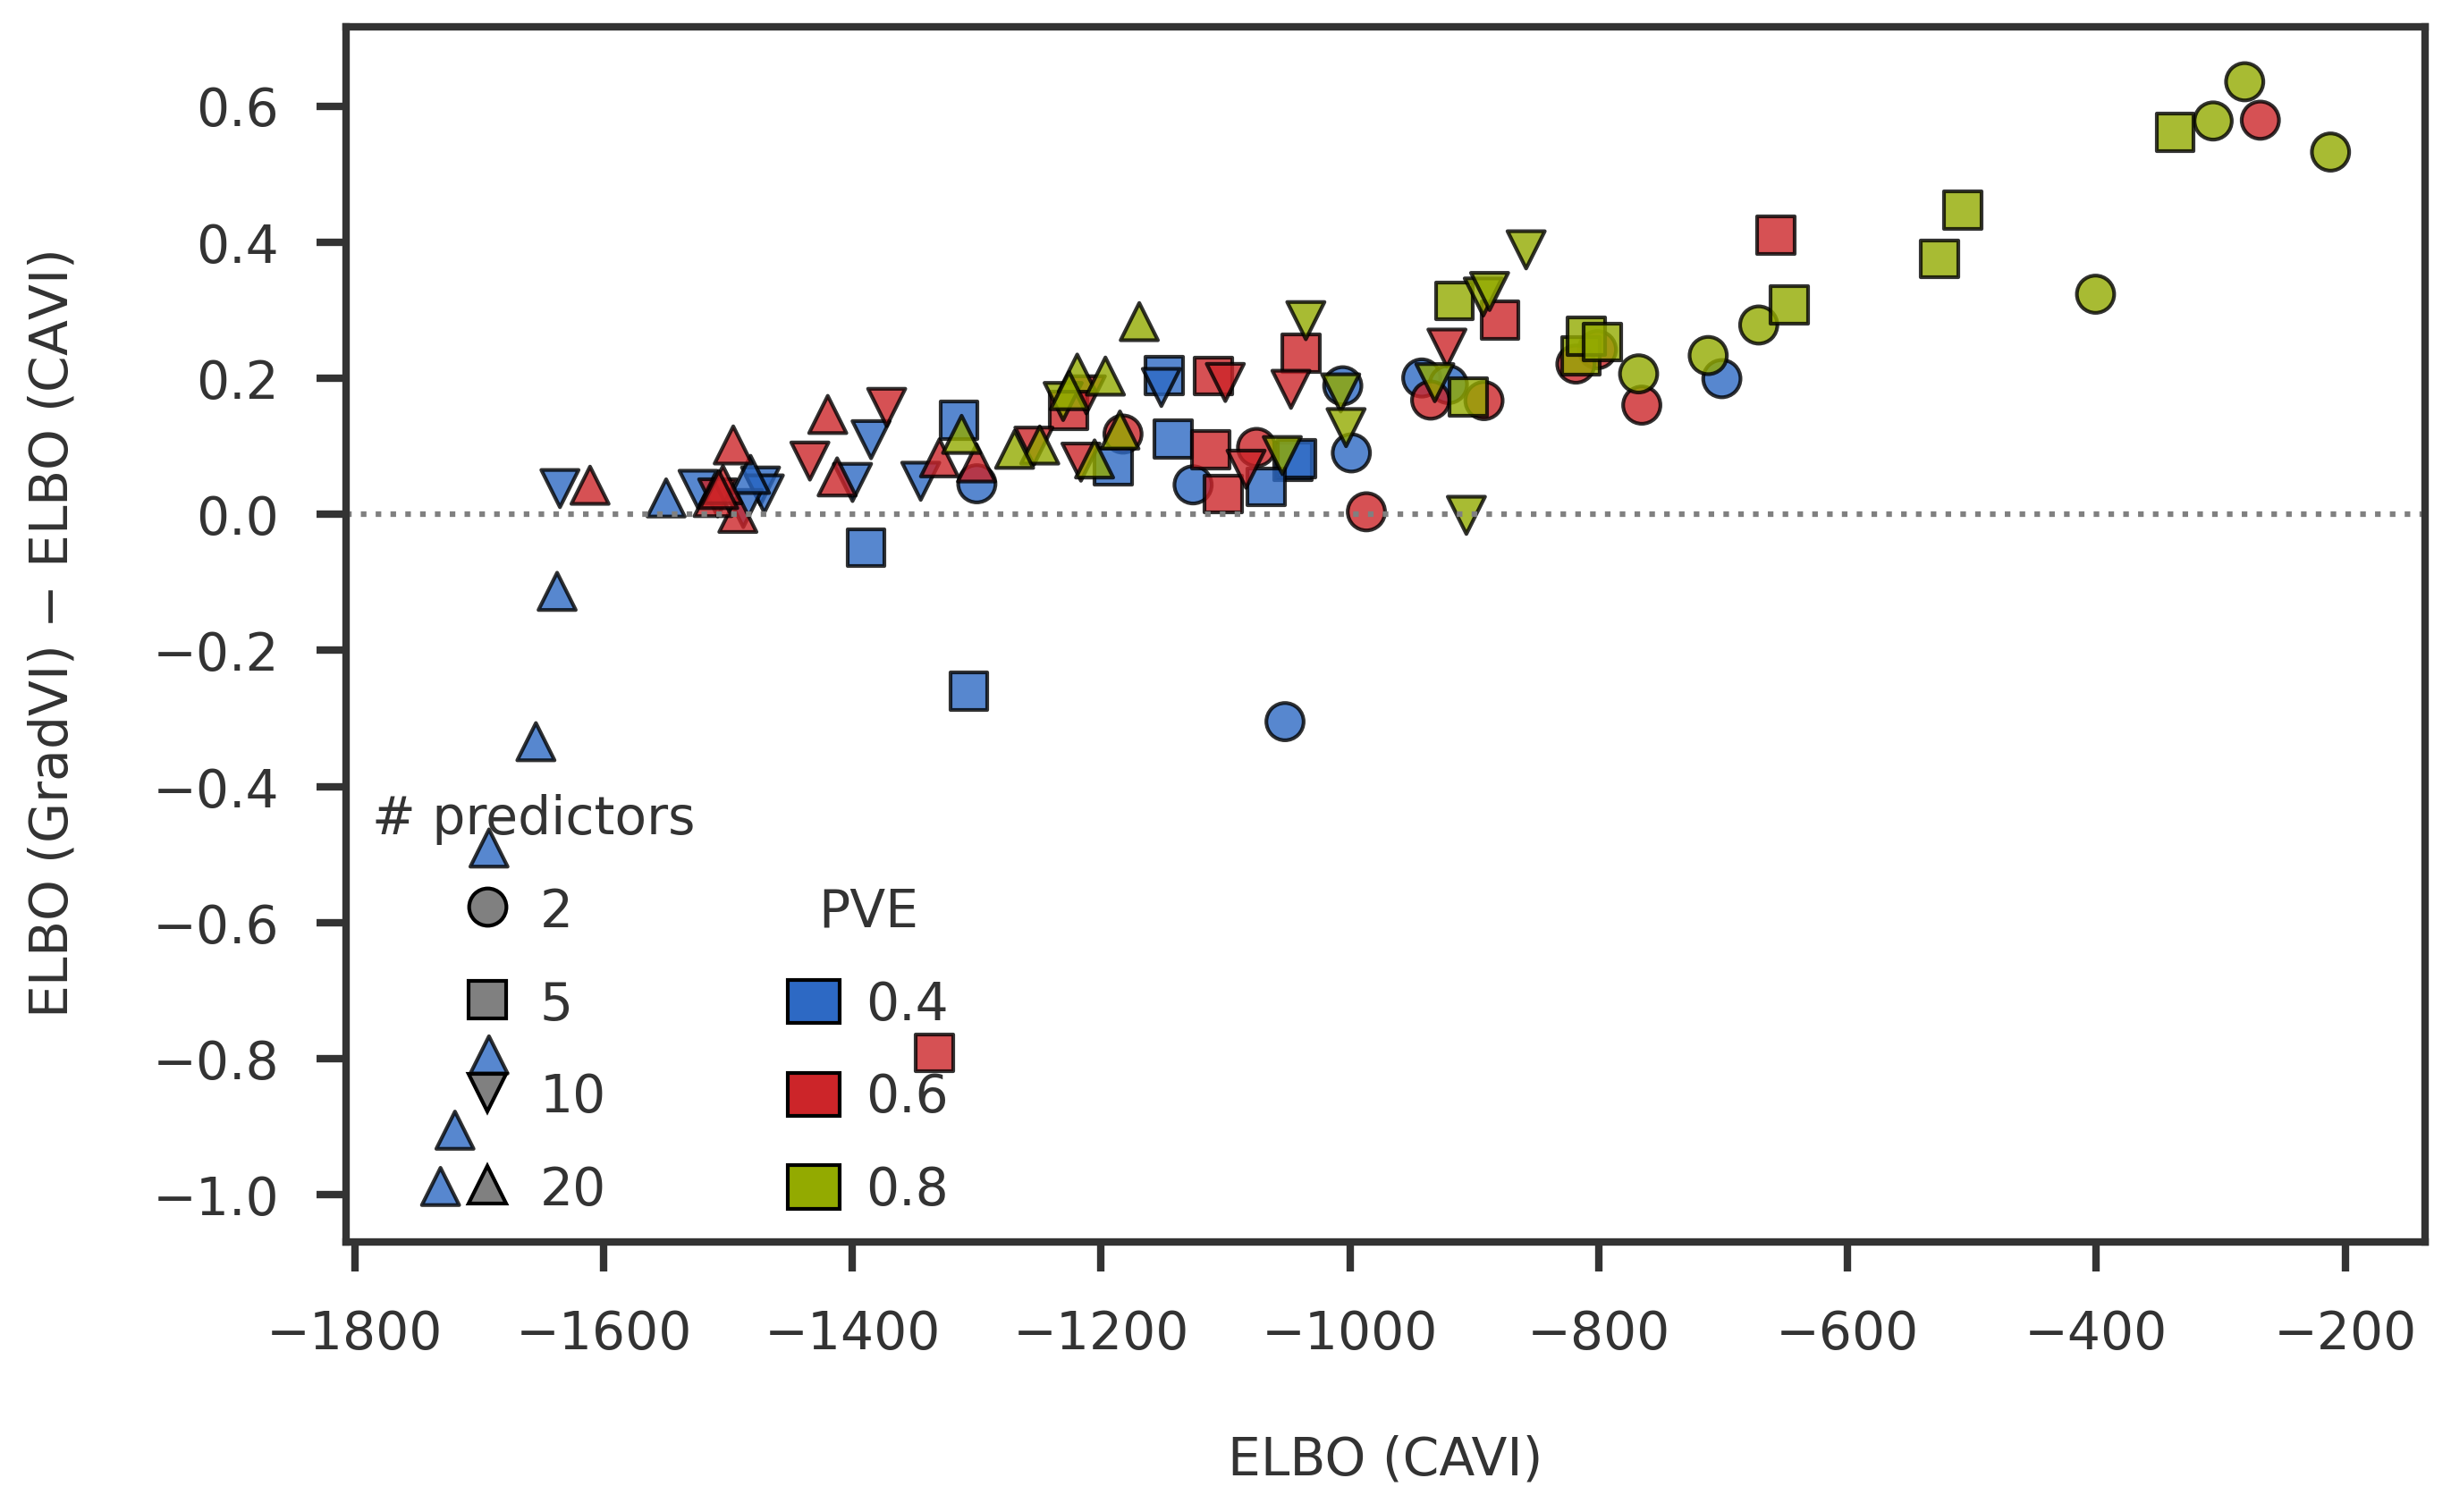

In [14]:
fig = plt.figure(figsize = (10, 6))
ax1 = fig.add_subplot(111)

def np_categorize(arr):
    unq = np.unique(arr)
    d1  = {x : i for i, x in enumerate(unq)}
    d2  = {i : x for i, x in enumerate(unq)}
    return np.array([d1[x] for x in arr]), d2

def plot_elbo_scatter(ax, df, reference, target, has_outliers = False, use_gradvi_alternate = False):
    ## filter convergence
    df = df[df[f"{reference}_status"] != 2]
    df = df[df[f"{target}_status"] != 2]
    
    ## get values
    ref   = - df[reference].to_numpy()
    tgt   = - df[target].to_numpy()
    if use_gradvi_alternate and target.startswith("gradvi"):
        alt_target = "gradvi_direct" if target == "gradvi_compound" else "gradvi_compound"
        tgt2 = - df[alt_target].to_numpy()
        tgt  = np.maximum(tgt, tgt2)
    diff  = tgt - ref
    
    sfixidx, sfixvals = np_categorize(df['simulate.sfix'].to_numpy())
    pveidx,  pvevals  = np_categorize(df['simulate.pve'].to_numpy())
    
    if has_outliers:
        iremove = np.array([])
        ikeep   = np.arange(diff.shape[0])
    else:
        iremove, ikeep = outlier_index_normal(diff, factor = 10.0)
        print (f"Number of outliers removed : {iremove[0].shape[0]}")
        for i in iremove[0]:
            print(f"Index {i},\tPVE={pvevals[pveidx[i]]}, s={sfixvals[sfixidx[i]]}\t diff = {diff[i]:g}")
    mcolors  = mpl_stylesheet.banskt_colors()
    mmarkers = ['o', 's', 'v', '^', '<', '>', 'p', 'h', 'H', 'D', 'd']
    
    markers = [mmarkers[i] for i in sfixidx[ikeep]]
    
    for sidx, sfix in sfixvals.items():
        marker = mmarkers[sidx]
        #print (sidx, sfix, marker)
        _idx = np.where(sfixidx == sidx)[0]
        _ikeep  = np.intersect1d(_idx, ikeep, assume_unique = True)
        _colors = [mcolors[i] for i in pveidx[_ikeep]]
        ax.scatter(ref[_ikeep], diff[_ikeep], marker = marker, c = _colors,
                   alpha = 0.8, s = 100, edgecolors = 'black', label = f"{sfix}")
    ax.axhline(y = 0, linestyle = 'dotted', color = 'gray')
    
    # legend for number of causal predictors
    mhandles = list()
    mlabels  = list()
    for sidx, sfix in sfixvals.items():
        marker = mmarkers[sidx]
        handle = mlines.Line2D([], [], color='grey', mec='black', marker=marker, ls='', ms=10)
        mhandles.append(handle)
        mlabels.append(f"{sfix}")
    leg1 = plt.legend(handles = mhandles, labels = mlabels, title = r"# predictors",
                      loc = 'lower left', bbox_to_anchor = (0.0, 0.0))
    plt.gca().add_artist(leg1)
    
    # legend for PVE
    mhandles = list()
    mlabels  = list()
    for pidx, pve in pvevals.items():
        color = mcolors[pidx]
        handle = mpatches.Patch(facecolor = color, edgecolor = 'black')
        mhandles.append(handle)
        mlabels.append(f"{pve}")
    leg2 = ax.legend(handles = mhandles, labels = mlabels, title = r"PVE",
                     loc = 'lower left', bbox_to_anchor = (0.2, 0.0))
    
    return

plot_elbo_scatter(ax1, elbodf, "mr_ash_lasso_init", "gradvi_compound", 
                  has_outliers = False, use_gradvi_alternate = False)
ax1.set_xlabel("ELBO (CAVI)")
ax1.set_ylabel(r"ELBO (GradVI) $-$ ELBO (CAVI)")
plt.show()